# Counterfactual Analysis - Temperature Changes Based on the Industrial Revolution (1760-1840)

In [447]:
#!pip install mkl-service
#!pip install pymc3

In [448]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from pymc.math import logsumexp
from pymc.variational.callbacks import CheckParametersConvergence
import datetime
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

import scipy.fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import mkl
import pymc3 as pm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.dates as mdates

In [449]:
country_temp = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

In [450]:
country_temp.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe
577461,2013-09-01,NaN,NaN,Zimbabwe


In [451]:
country_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


In [452]:
# Assuming 'us_temp' is your DataFrame and 'AverageTemperatureUncertainty' is the column name
min_value = country_temp['AverageTemperatureUncertainty'].min()
max_value = country_temp['AverageTemperatureUncertainty'].max()

# Rescale the column to range from 0 to 1
country_temp['AverageTemperatureUncertainty'] = (country_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


In [453]:
country_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,0.064682
std,10.953966,0.080391
min,-37.658000,0.000000
25%,10.025000,0.018126
50%,20.901000,0.034713
75%,25.814000,0.077185
max,38.842000,1.000000


In [454]:
country_temp.isnull().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [455]:
country_temp['Country'].unique()

array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecu

In [456]:
us_temp = country_temp[country_temp['Country'].isin(['United States'])]


In [457]:
us_temp['dt'] = pd.to_datetime(us_temp['dt'])
us_temp['Year'] = us_temp['dt'].dt.year
us_temp['pre'] = us_temp['Year'] <= 1840
us_temp['line'] = us_temp.reset_index().index

<ipython-input-457-dc19b553ea61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['dt'] = pd.to_datetime(us_temp['dt'])
<ipython-input-457-dc19b553ea61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['Year'] = us_temp['dt'].dt.year
<ipython-input-457-dc19b553ea61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [458]:
# Assuming 'us_temp' is your DataFrame containing temperature data

# Convert 'dt' column to datetime if it's not already in datetime format
us_temp['dt'] = pd.to_datetime(us_temp['dt'])

# Extract the year from the 'dt' column
us_temp['Year'] = us_temp['dt'].dt.year


<ipython-input-458-2dfe078c4a14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['dt'] = pd.to_datetime(us_temp['dt'])
<ipython-input-458-2dfe078c4a14>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['Year'] = us_temp['dt'].dt.year


In [459]:
us_temp.shape

(2941, 7)

In [460]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year,pre,line
554880,1768-09-01,15.420,0.189151,United States,1768,True,0
554881,1768-10-01,8.162,0.222995,United States,1768,True,1
554882,1768-11-01,1.591,0.249549,United States,1768,True,2
554883,1768-12-01,-2.882,0.329543,United States,1768,True,3
554884,1769-01-01,-3.952,0.321316,United States,1769,True,4


In [461]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,Year,line
count,2482.000000,2482.000000,2941.000000,2941.000000
mean,8.603573,0.052115,1890.708262,1470.000000
std,8.976109,0.062181,70.762354,849.137896
min,-7.581000,0.000067,1768.000000,0.000000
25%,0.256250,0.008428,1829.000000,735.000000
50%,8.564000,0.019430,1891.000000,1470.000000
75%,17.286000,0.081851,1952.000000,2205.000000
max,23.008000,0.353488,2013.000000,2940.000000


In [462]:
import xarray as xr
import pytensor.tensor as pt

In [463]:
%config InlineBackend.figure_format = 'retina'
random_seed = 8927
rng = np.random.default_rng(random_seed)
az.style.use("arviz-darkgrid")

In [464]:
us_temp.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Year', 'pre', 'line'],
      dtype='object')

In [465]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')

us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])


<ipython-input-465-b6b0be15b085>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])


In [466]:
us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')

<ipython-input-466-4ee5fd21d919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')


In [467]:
# Find indices of rows corresponding to the maximum temperature for each year
max_temp_indices = us_temp.groupby('Year')['AverageTemperature'].idxmax()

# Use the obtained indices to extract rows with maximum temperature for each year
us_temp = us_temp.loc[max_temp_indices, ['Year', 'AverageTemperature', 'AverageTemperatureUncertainty']]

# Display the DataFrame showing the maximum temperature and its uncertainty for each year
us_temp['line'] = range(len(us_temp))

# Add pre-1840 boolean column
us_temp['pre'] = us_temp['Year'] < 1840
print(us_temp)

        Year  AverageTemperature  AverageTemperatureUncertainty  line    pre
554880  1768           15.420000                       0.189151     0   True
554890  1769           22.093000                       0.215705     1   True
554896  1770           19.856113                       0.052115     2   True
554908  1771           17.621984                       0.052115     3   True
554920  1772           15.387855                       0.052115     4   True
...      ...                 ...                            ...   ...    ...
557770  2009           21.463000                       0.015718   241  False
557782  2010           22.078000                       0.011839   242  False
557794  2011           22.722000                       0.011237   243  False
557806  2012           23.008000                       0.015116   244  False
557818  2013           22.074000                       0.006689   245  False

[246 rows x 5 columns]


In [468]:
us_temp.shape

(246, 5)

In [469]:
# helper functions to support the analysis
import calendar
import os
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)


# default figure sizes
figsize = (10, 5)

# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [470]:
us_temp.columns

Index(['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'line',
       'pre'],
      dtype='object')

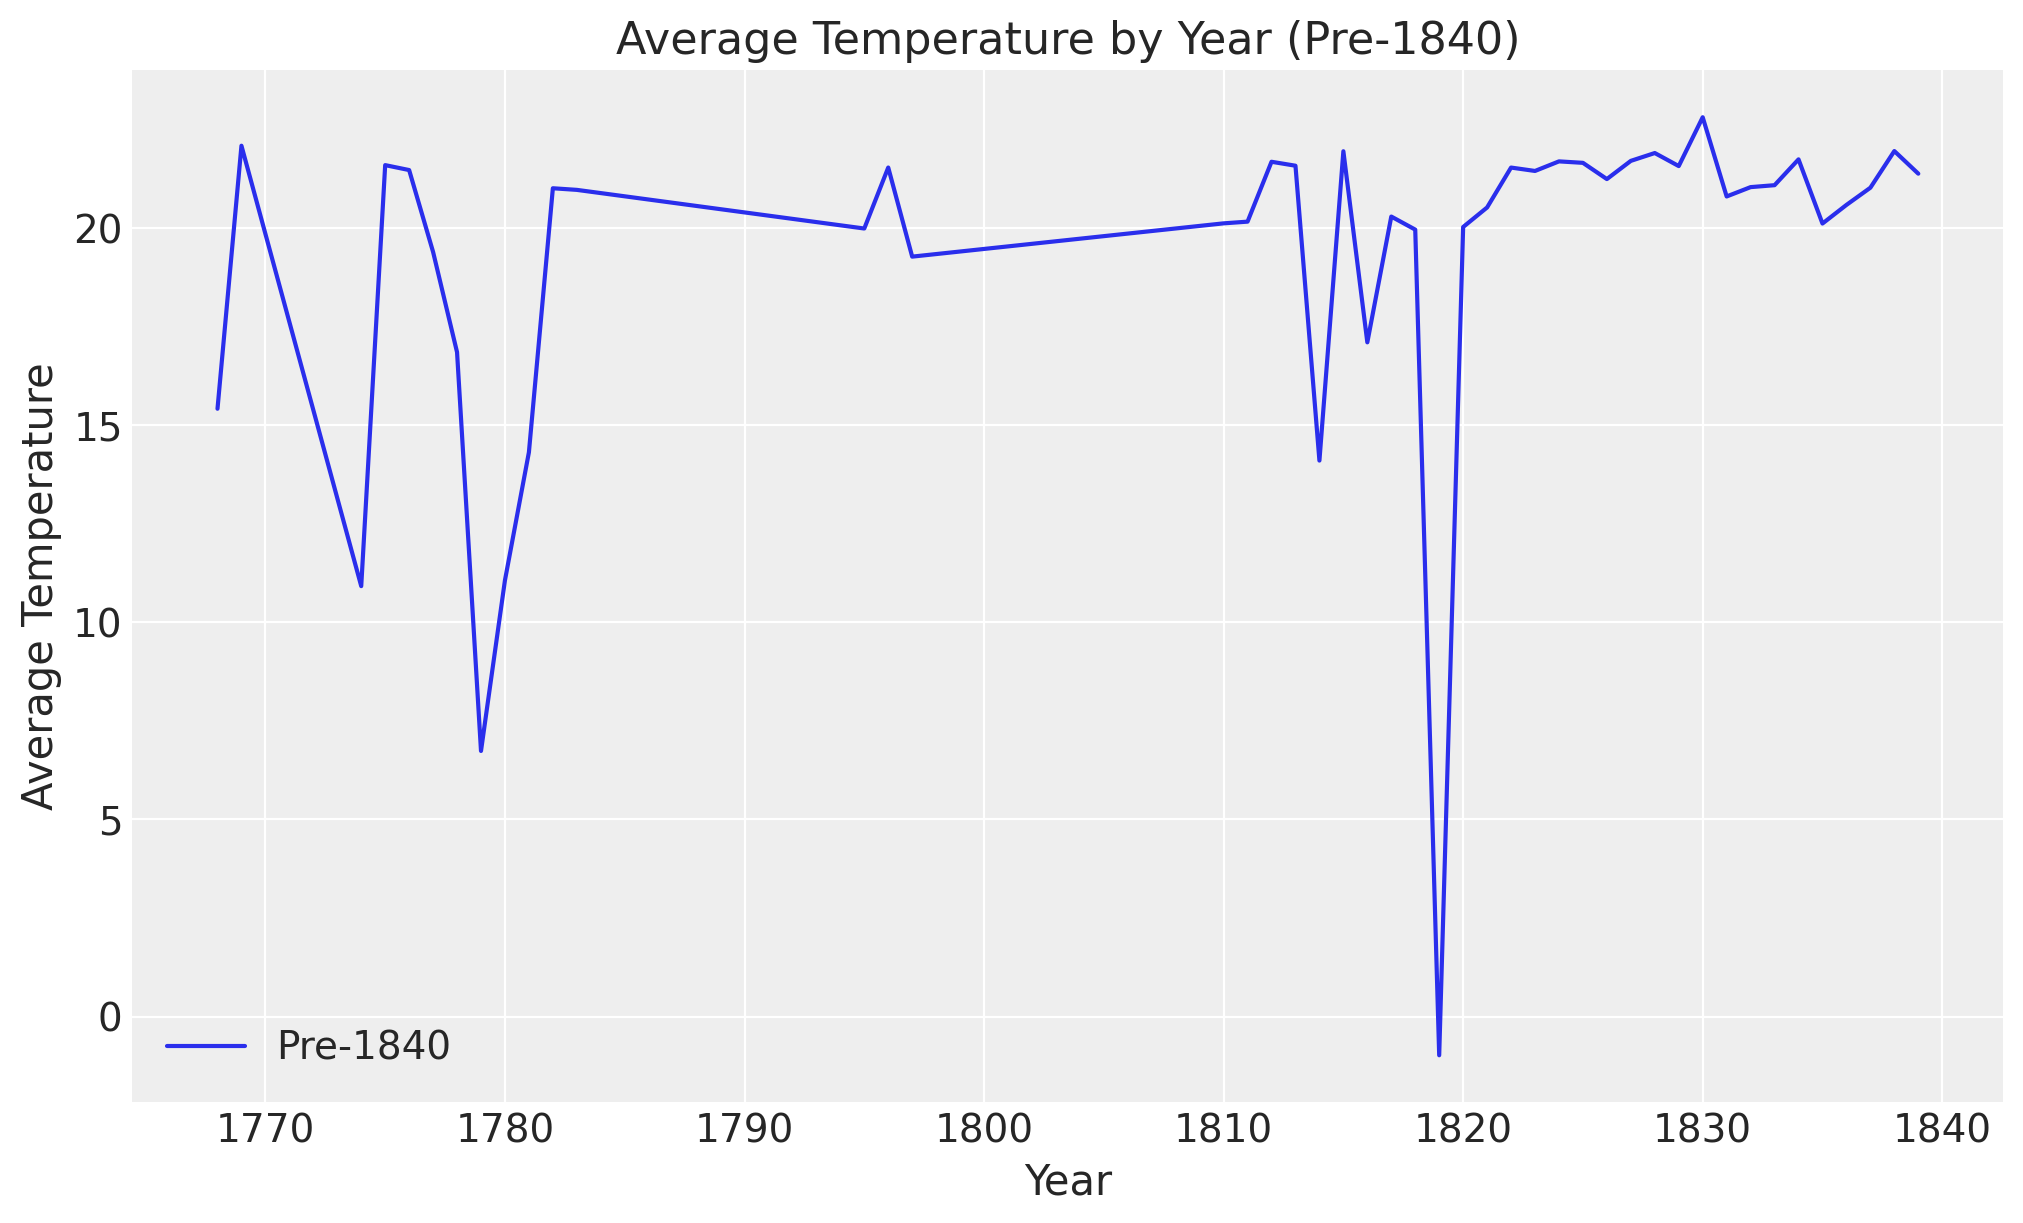

In [474]:
pre_1840_data = us_temp[us_temp['pre']]

# Create the plot using Seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=pre_1840_data, x='Year', y='AverageTemperature', label='Pre-1840', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Temperature by Year (Pre-1840)')

plt.legend()
plt.show()


In [485]:
us_temp.columns

Index(['Year', 'AverageTemperature', 'AverageTemperatureUncertainty', 'line',
       'pre'],
      dtype='object')

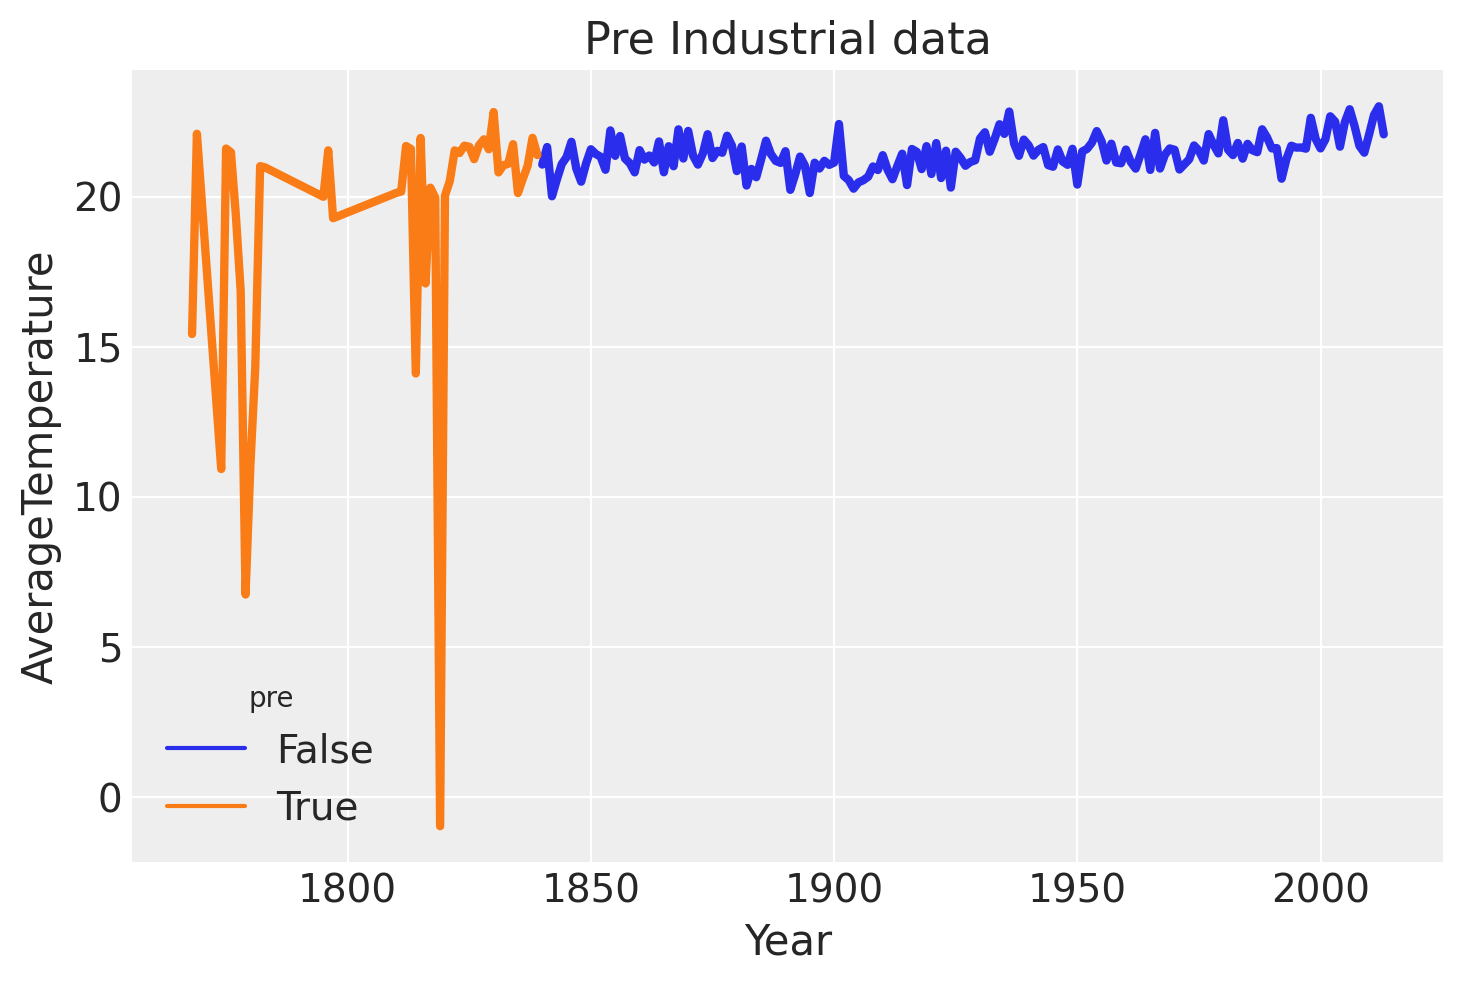

In [486]:
ax = sns.lineplot(data=us_temp, x="Year", y="AverageTemperature", hue="pre", lw=3)
ax.set(title="Pre Industrial data")

plt.show()

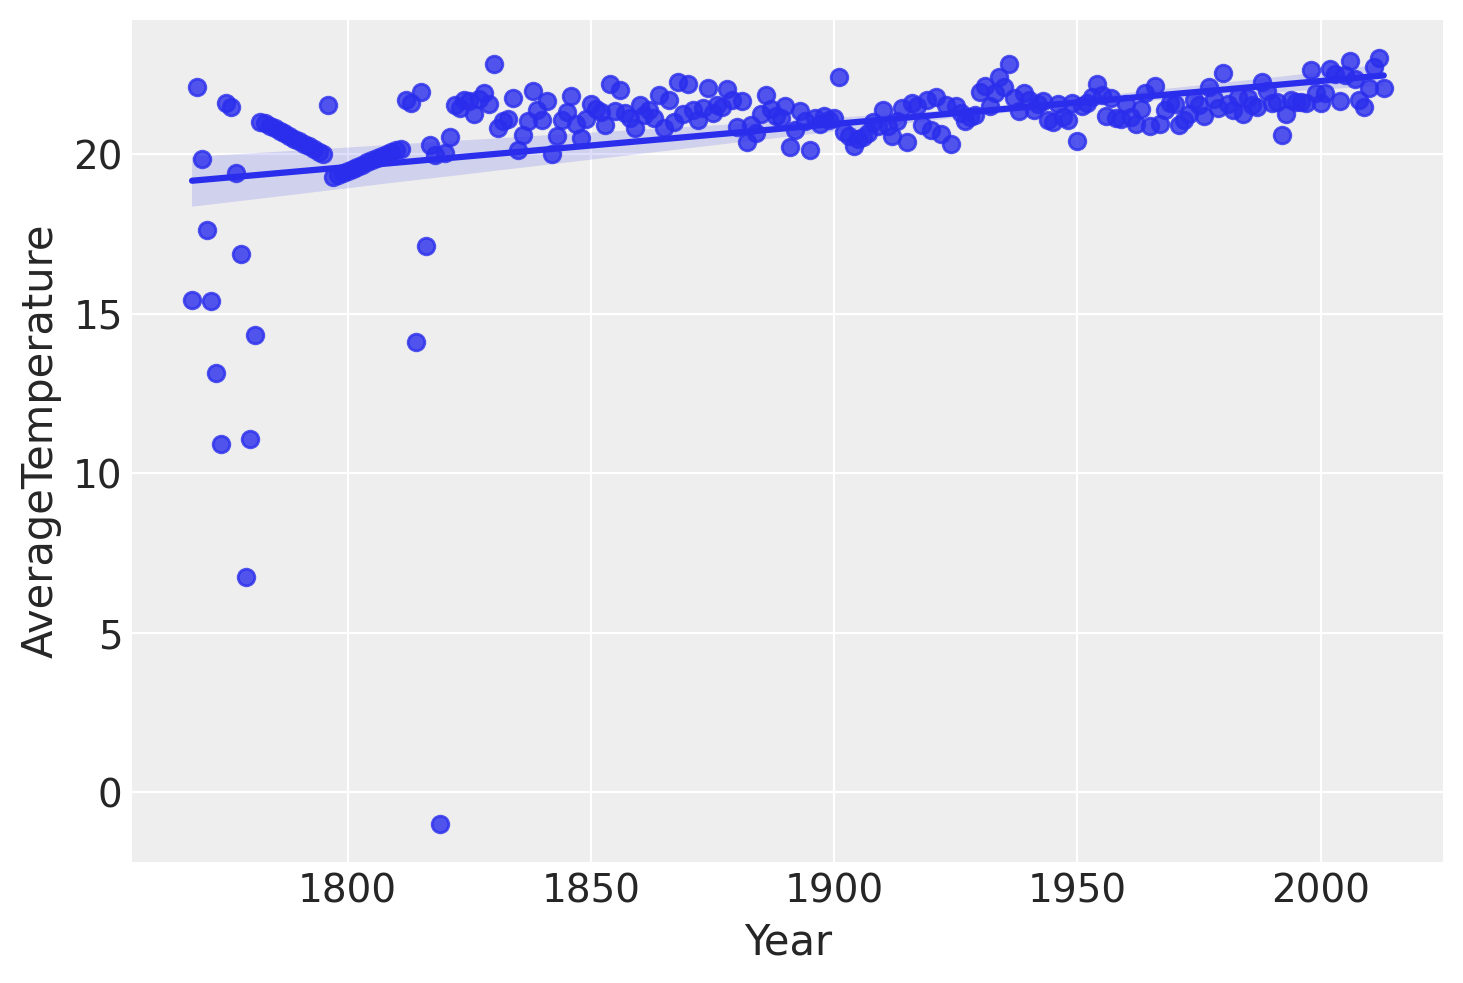

In [487]:
sns.regplot(x="Year", y="AverageTemperature", data=us_temp);

[Text(0.5, 1.0, 'Quadratic fit (us_temp data)')]

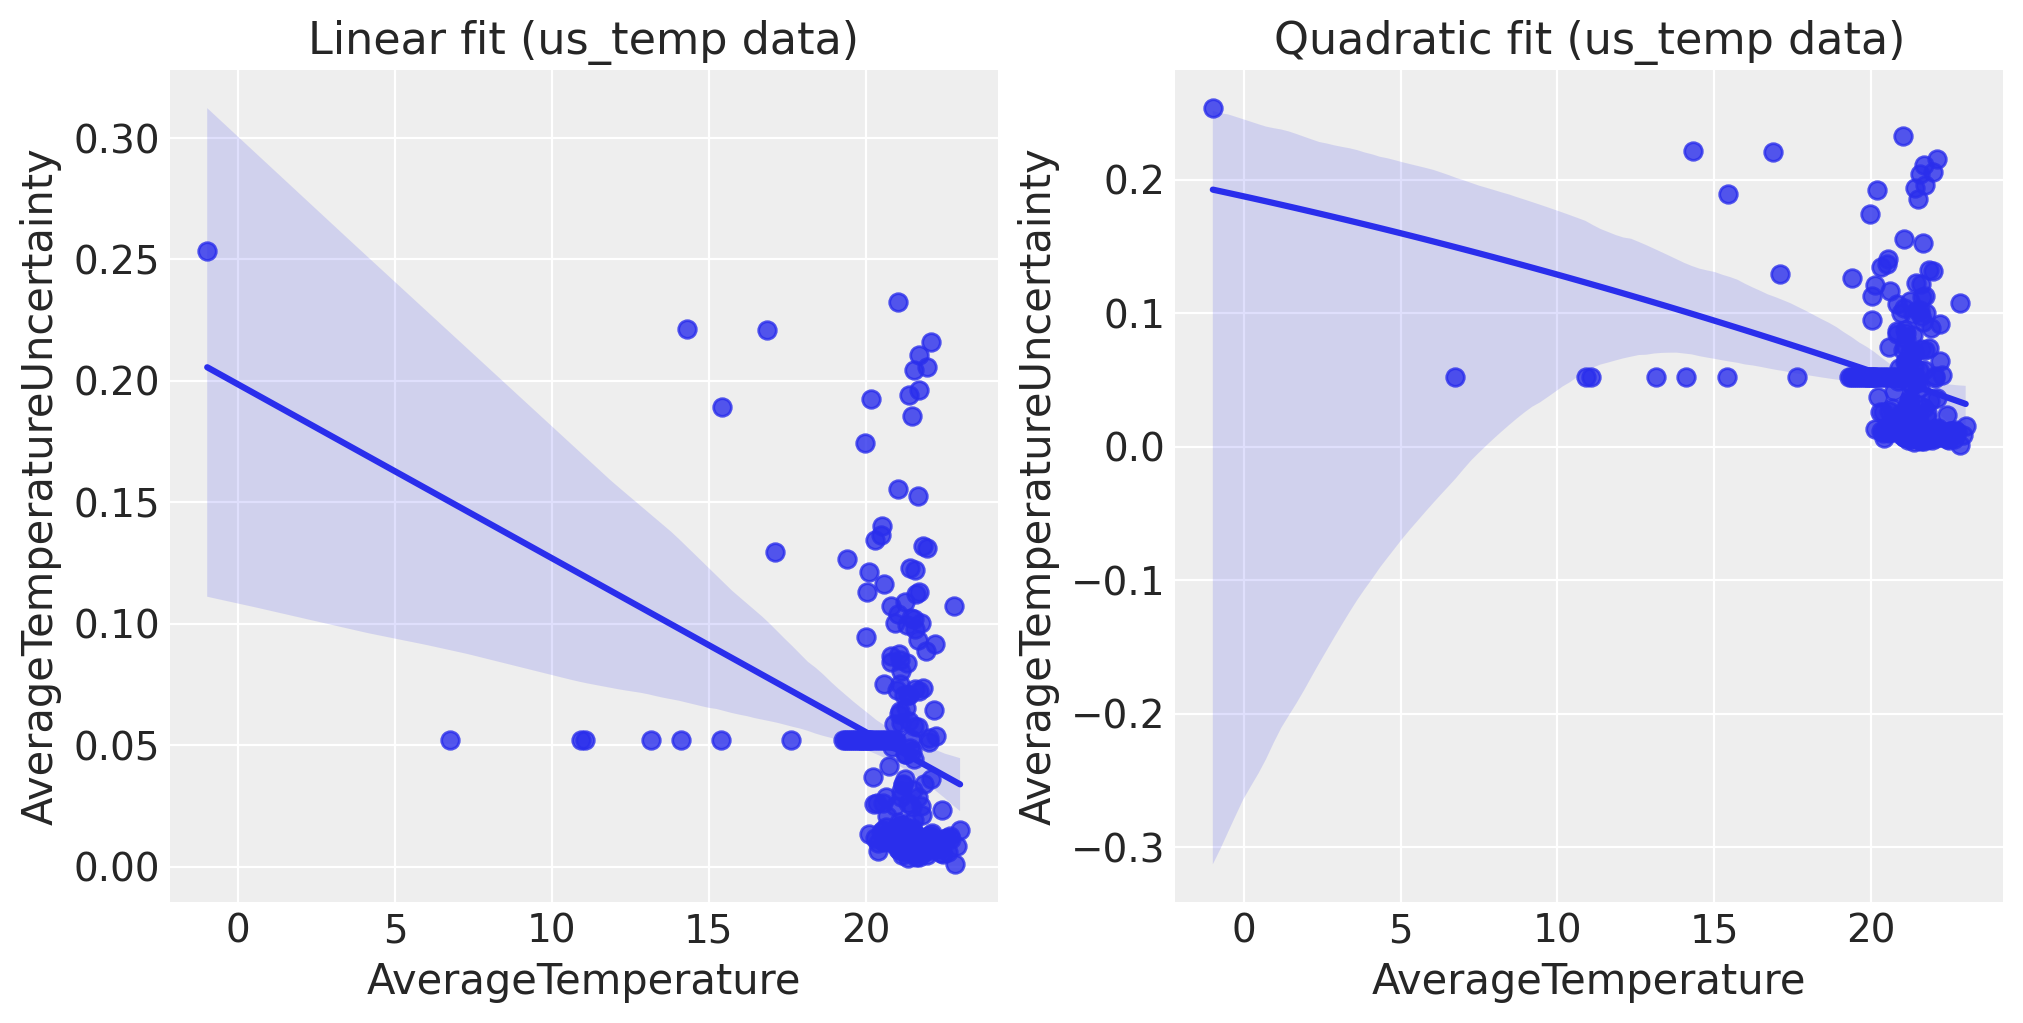

In [489]:
fig, ax = plt.subplots(1, 2, figsize=figsize)

# Linear fit
sns.regplot(x="AverageTemperature", y="AverageTemperatureUncertainty", data=us_temp, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (us_temp data)")

# Quadratic fit
sns.regplot(x="AverageTemperature", y="AverageTemperatureUncertainty", data=us_temp, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (us_temp data)")

Horizontal Lines: These lines often suggest that there's little to no variation or change in the data over time or between the specified categories. It might imply that for certain years or periods, the recorded average temperatures remained relatively constant, resulting in straight lines on the plot.

Bell-Shaped Lines: Bell-shaped lines typically indicate some sort of seasonality or cyclical pattern in the data. For temperature data, this shape could indicate that there's a cyclical pattern in the average temperatures throughout the year, where temperatures rise, peak, and then decline, forming a bell-shaped curve.

These shapes might also result from data preprocessing or aggregation, such as taking the mean or summarizing values for each month or year. They can also be artifacts of the data collection process or analysis methods.



In [475]:
import pymc3 as pm

# Assuming 'us_temp' is the DataFrame containing the US temperature data

with pm.Model(coords={"line": us_temp['line']}) as model:
    # observed predictors and outcome
    temperature = pm.Data("temperature", us_temp['AverageTemperature'].values)
    uncertainty = pm.Data("uncertainty", us_temp['AverageTemperatureUncertainty'].values)
    line = pm.Data("line", us_temp['line'].values)

    # priors
    intercept = pm.Normal("intercept", 40_000, 10_000)
    month_mu = pm.Normal("month_mu", mu=0, sigma=3000, dims="line")
    linear_trend = pm.TruncatedNormal("linear_trend", 0, 50, lower=0)
    temp_coeff = pm.Normal("temp_coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * line) + month_mu[line - 1] + (temp_coeff * temperature),
        dims="line",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("observed_temperature", mu=mu, sigma=sigma, lower=0, observed=uncertainty, dims="line")

    # Model graphic
    g = pm.model_to_graphviz()



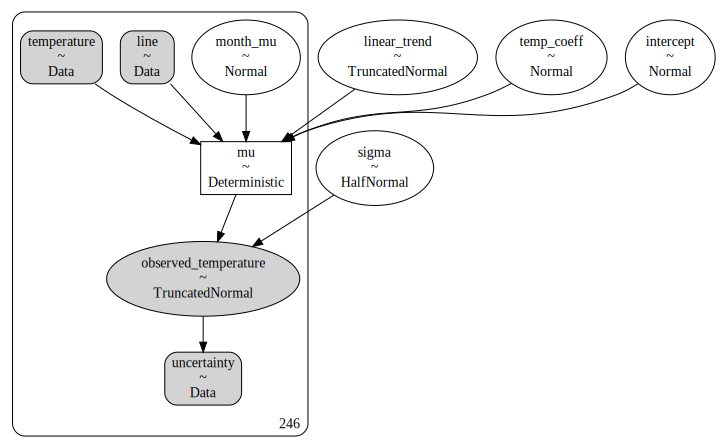

In [476]:
g

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
<ipython-input-477-129a1720b2d1>:36: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  12.497  1.127  10.400   14.573      0.016    0.012    4760.0    4466.0   
beta    1.261  0.978  -0.585    3.051      0.012    0.009    6582.0    5981.0   
sigma   6.234  0.694   4.886    7.457      0.010    0.007    4553.0    4714.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


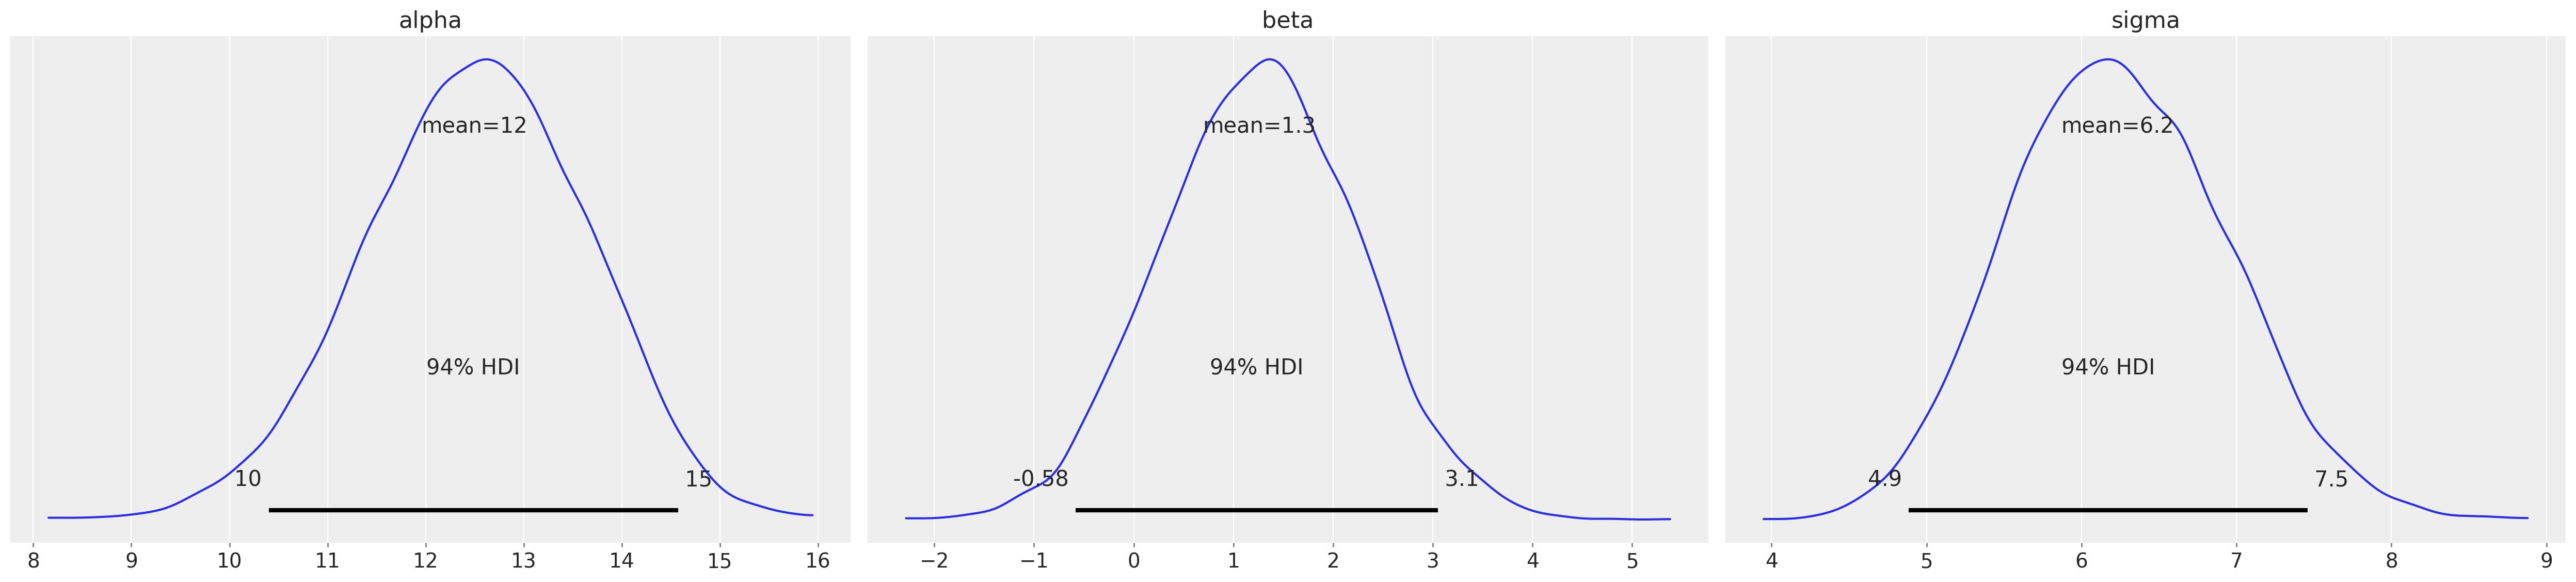

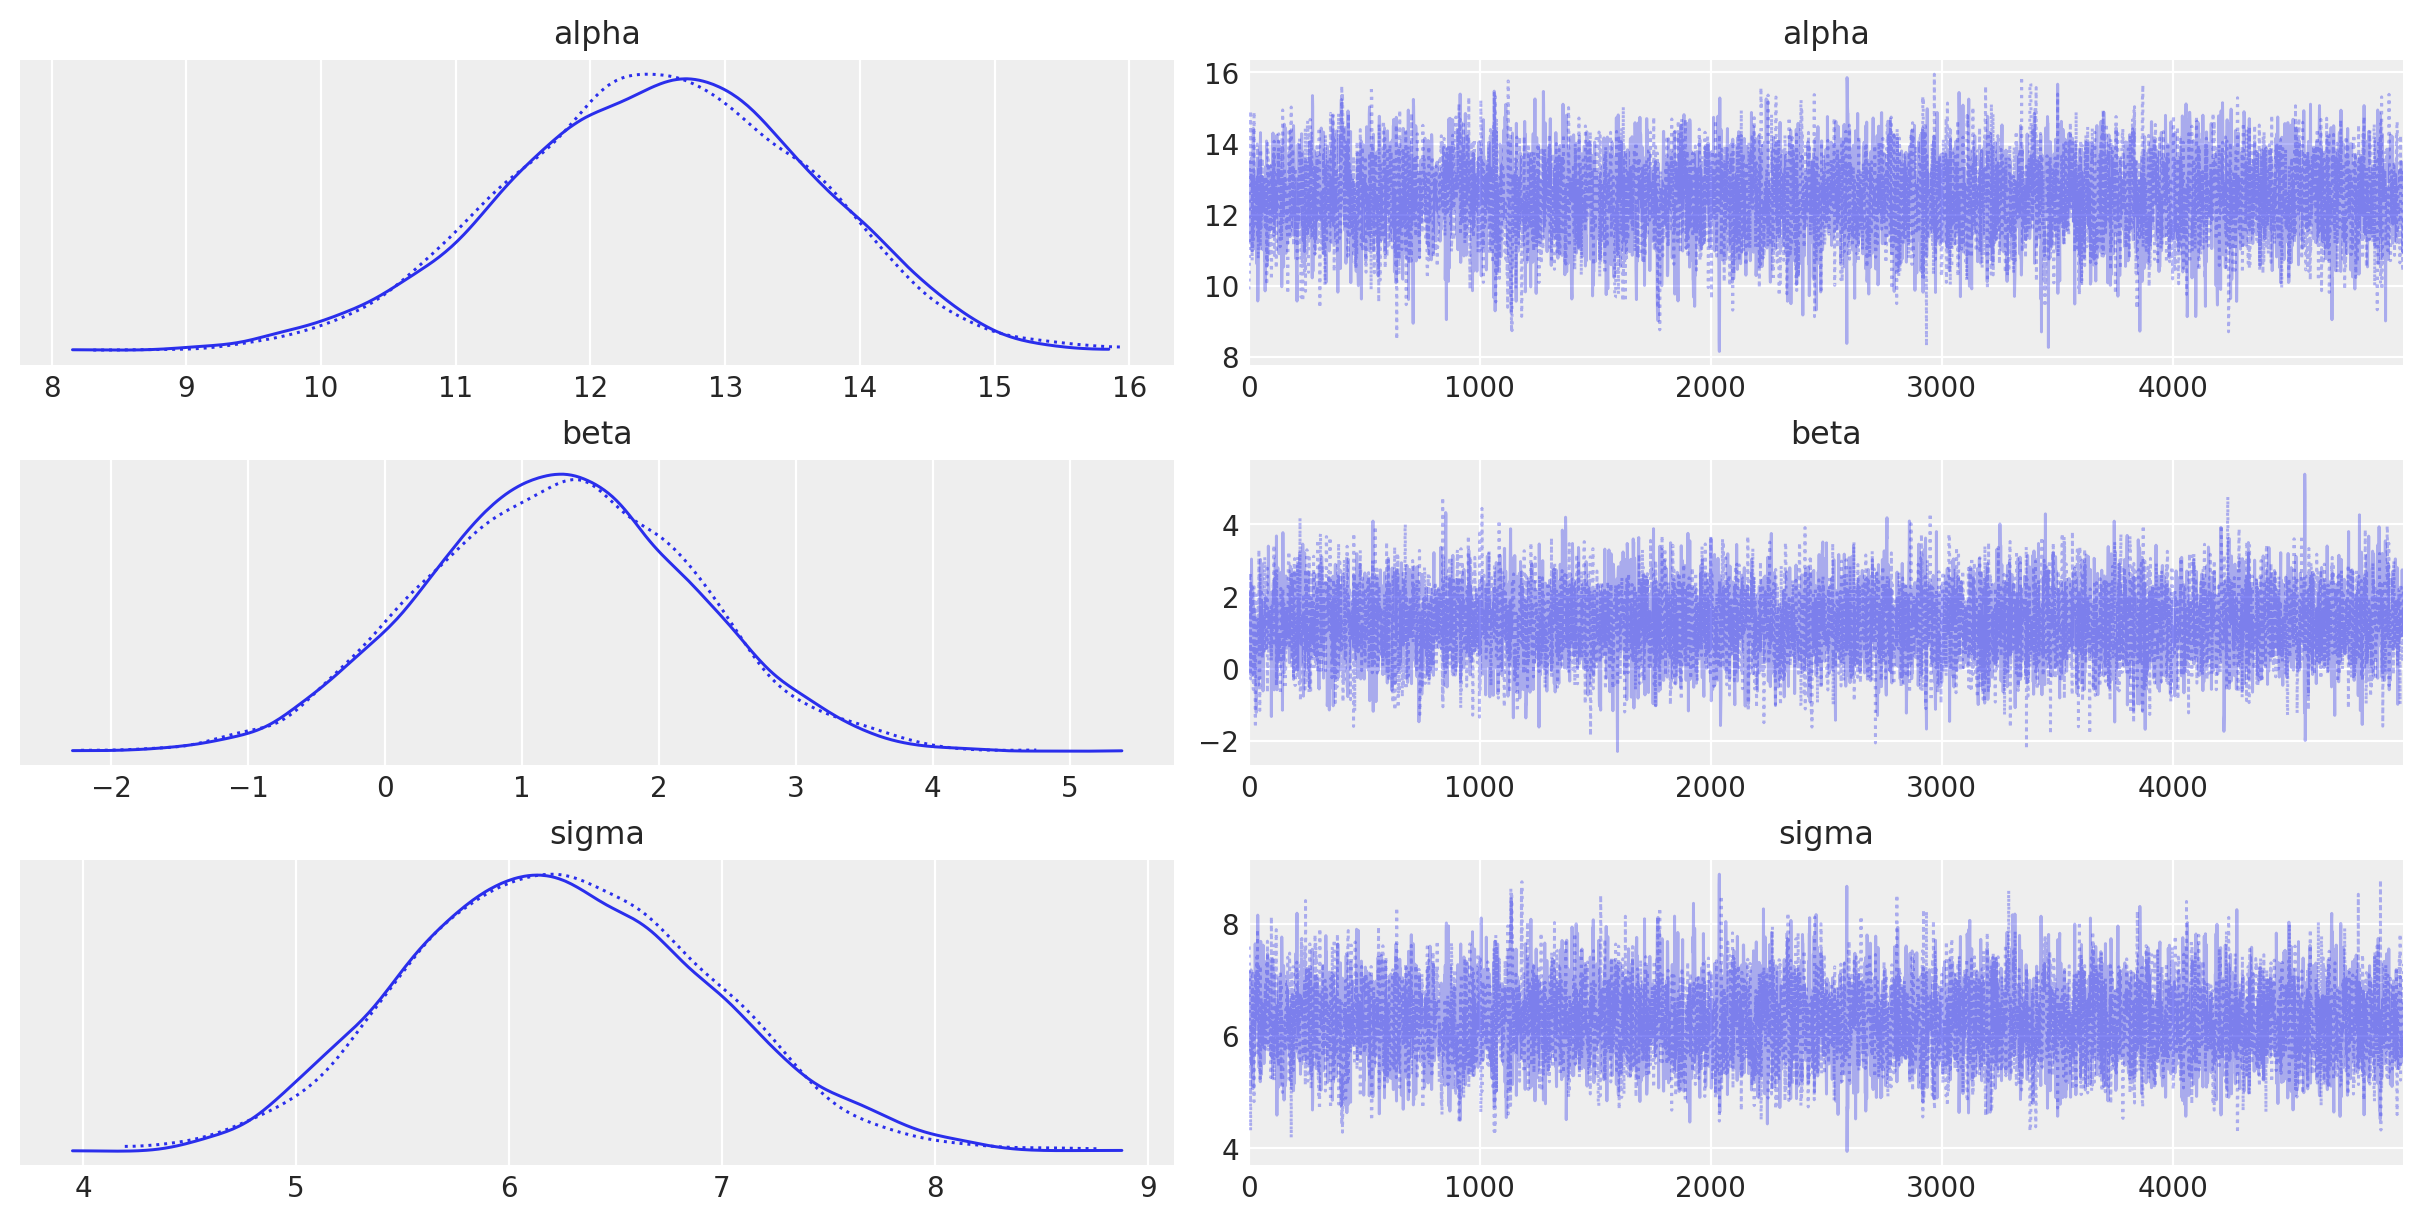

In [477]:
import pymc3 as pm

# Assuming 'us_temp' is your DataFrame containing pre and post-1840 data
# Splitting data into pre and post-1840 subsets
pre_1840 = us_temp[us_temp['Year'] < 1840]
post_1840 = us_temp[us_temp['Year'] >= 1840]

# Define Bayesian linear regression model
with pm.Model() as bayesian_model:
    # Priors for coefficients
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)

    # Linear regression model
    mu = alpha + beta * pre_1840['AverageTemperatureUncertainty']  # Use the appropriate feature(s) for regression

    # Likelihood (assuming normally distributed errors)
    sigma = pm.HalfNormal('sigma', sd=1)
    likelihood = pm.Normal('likelihood', mu=mu, sd=sigma, observed=pre_1840['AverageTemperature'])

    # Sample from the posterior
    trace = pm.sample(5000, tune=2000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=500, random_seed=42)

# Use the inferred model parameters to predict post-1840 temperatures
predicted_temperatures = trace['alpha'].mean() + trace['beta'].mean() * post_1840['AverageTemperatureUncertainty']

# Compare predictions with actual post-1840 temperatures
# Here, you can calculate metrics or visualize the differences between predicted and actual temperatures
# Plotting posterior distributions of coefficients
pm.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])

# Display summary statistics of the model
summary = pm.summary(trace)
print(summary)
pm.traceplot(trace)
plt.show()

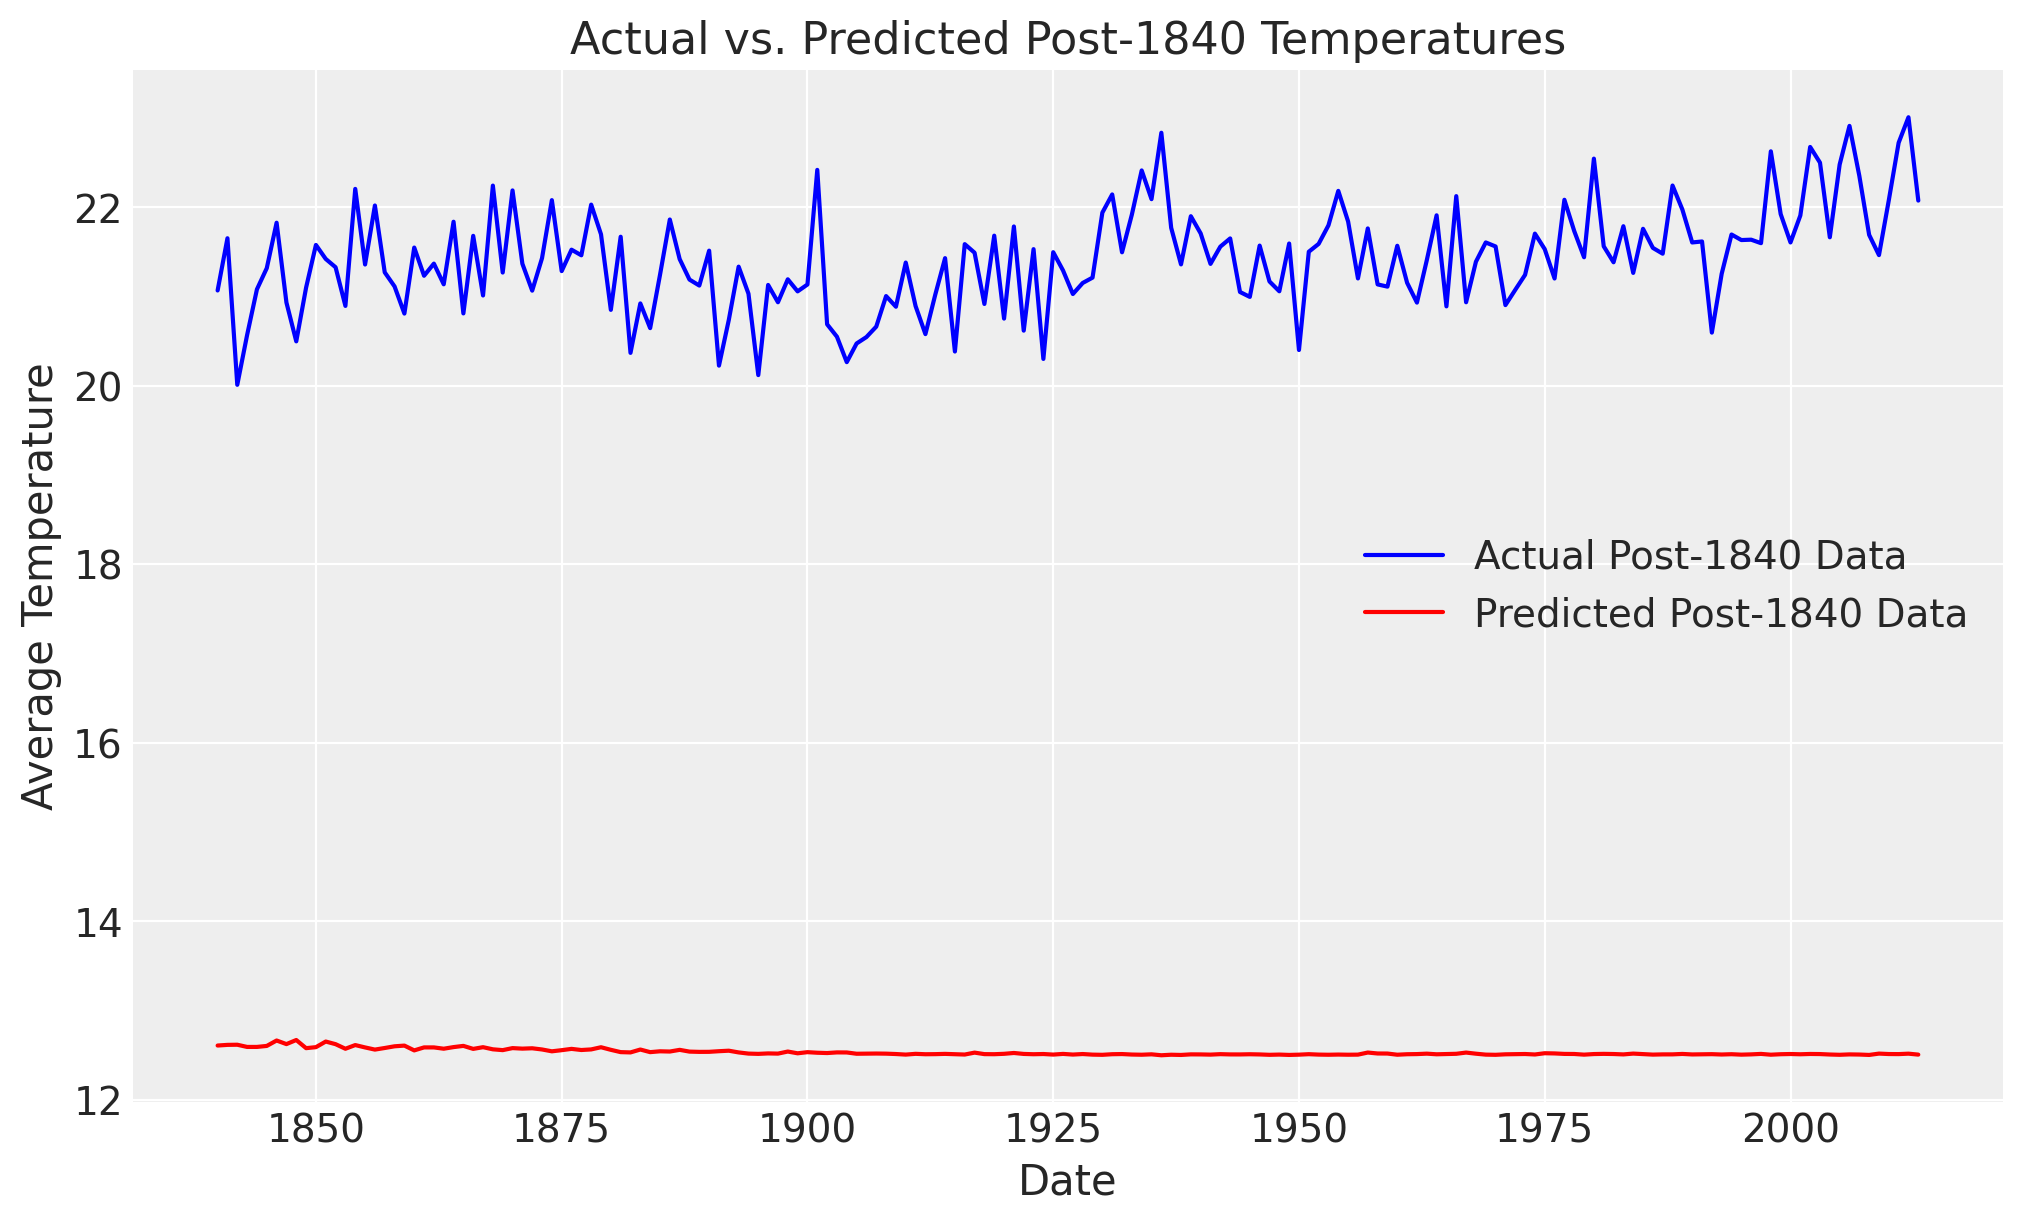

In [480]:
posterior_samples = posterior_predictive['likelihood']

# Plotting actual post-1840 temperatures
plt.figure(figsize=(10, 6))
plt.plot(post_1840['Year'], post_1840['AverageTemperature'], label='Actual Post-1840 Data', color='blue')

# Plotting predicted post-1840 temperatures
plt.plot(post_1840['Year'], predicted_temperatures, label='Predicted Post-1840 Data', color='red')

plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Actual vs. Predicted Post-1840 Temperatures')
plt.legend()
plt.show()

